# Conversor de Estresse - Native vs SUNDIALS (v1)

Notebook de estresse para validar robustez de transiente no kernel v1.

Objetivo:
- rodar o mesmo conversor com backend nativo e SUNDIALS (IDA/CVODE/ARKODE);
- comparar formulacao `projected_wrapper` vs `direct` (strict e auto-fallback);
- incluir cenarios de `HybridAuto` (Native -> SUNDIALS -> Native);
- verificar convergencia em cold-start e warm-start;
- comparar custo computacional, eventos/reinicializacoes e diferenca numerica em Vout.


In [1]:
from pathlib import Path
import importlib
import sys

_root = Path.cwd()
_candidates = []
for _ in range(8):
    for _rel in (
        ("build-sundials-py313", "python"),
        ("build-sundials", "python"),
        ("build-test", "python"),
        ("build", "python"),
    ):
        candidate = (_root / _rel[0] / _rel[1]).resolve()
        if candidate.is_dir():
            _candidates.append(candidate)
    _root = _root.parent

# Remove duplicates while preserving order
_seen = set()
_candidates = [c for c in _candidates if not (str(c) in _seen or _seen.add(str(c)))]

if not _candidates:
    raise RuntimeError("Nenhum build/python encontrado (build-sundials, build-test, build).")

abi_tag = f"cpython-{sys.version_info.major}{sys.version_info.minor}"
valid_candidates = []
abi_mismatch = []

for candidate in _candidates:
    pulsim_pkg = candidate / "pulsim"
    so_files = sorted(pulsim_pkg.glob("_pulsim*.so"))
    if not so_files:
        continue

    matching = [p for p in so_files if abi_tag in p.name]
    if matching:
        newest = max(matching, key=lambda p: p.stat().st_mtime)
        valid_candidates.append((candidate, newest))
    else:
        abi_mismatch.append((candidate, [p.name for p in so_files]))

if not valid_candidates:
    details = "\n".join(
        f"- {c}: {', '.join(names)}" for c, names in abi_mismatch
    )
    raise RuntimeError(
        "Nao achei build compativel com o Python atual. "
        f"Esperado ABI '{abi_tag}'.\nDisponiveis:\n{details}"
    )

# Prefer the newest compatible extension binary
valid_candidates.sort(key=lambda item: item[1].stat().st_mtime, reverse=True)
ordered_candidates = [c for c, _ in valid_candidates]

ps = None
_errors = []

for candidate in ordered_candidates:
    cstr = str(candidate)
    sys.path = [p for p in sys.path if p != cstr]
    sys.path.insert(0, cstr)

    for mod in list(sys.modules):
        if mod == "pulsim" or mod.startswith("pulsim."):
            del sys.modules[mod]

    try:
        importlib.invalidate_caches()
        import pulsim as _ps
        if not hasattr(_ps, "TransientBackendMode"):
            raise ImportError("pulsim sem TransientBackendMode (build antigo)")
        ps = _ps
        print(f"Usando pulsim de: {candidate}")
        print(f"Extensao: {_ps._pulsim.__file__}")
        print(f"Python runtime: {sys.version.split()[0]} | ABI esperado: {abi_tag}")
        break
    except Exception as exc:
        _errors.append(f"{candidate}: {exc}")

if ps is None:
    msg = "\n".join(_errors)
    raise RuntimeError("Falha ao importar pulsim atualizado:\n" + msg)

import numpy as np
import matplotlib.pyplot as plt
import time

print(f"Pulsim version: {ps.__version__}")
print("Backend capabilities:", ps.backend_capabilities())


Usando pulsim de: /Users/lgili/Documents/01 - Codes/01 - Github/PulsimCore/build-sundials-py313/python
Extensao: /Users/lgili/Documents/01 - Codes/01 - Github/PulsimCore/build-sundials-py313/python/pulsim/_pulsim.cpython-313-darwin.so
Python runtime: 3.13.5 | ABI esperado: cpython-313
Pulsim version: 0.4.1
Backend capabilities: {'klu': True, 'hypre_amg': False, 'sundials': True}


## 1) Circuito de estresse

Modelo usado:
- fonte PWM ideal (entrada chaveada);
- estagio LC principal;
- cadeia RC multipla na saida para aumentar ordem e rigidez numerica.

Esse arranjo costuma ser mais pesado para Newton + integracao implicita.


In [2]:
def create_stress_converter(
    v_high=48.0,
    v_low=0.0,
    fsw=120e3,
    duty=0.42,
    l_main=220e-6,
    c_main=47e-6,
    rc_sections=8,
):
    ckt = ps.Circuit()
    gnd = ckt.ground()

    n_sw = ckt.add_node("sw")

    pwm = ps.PWMParams()
    pwm.v_high = v_high
    pwm.v_low = v_low
    pwm.frequency = fsw
    pwm.duty = duty
    pwm.rise_time = 20e-9
    pwm.fall_time = 20e-9
    ckt.add_pwm_voltage_source("Vpwm", n_sw, gnd, pwm)

    n_l = ckt.add_node("l_out")
    ckt.add_inductor("L_main", n_sw, n_l, l_main, 0.0)
    ckt.add_capacitor("C_main", n_l, gnd, c_main, 0.0)

    prev = n_l
    for k in range(rc_sections):
        n_rc = ckt.add_node(f"rc_{k}")
        r_val = 0.20 + 0.05 * k
        c_val = 4.7e-6 / (1.0 + 0.20 * k)
        ckt.add_resistor(f"R_{k}", prev, n_rc, r_val)
        ckt.add_capacitor(f"C_{k}", n_rc, gnd, c_val, 0.0)
        prev = n_rc

    ckt.add_resistor("R_load", prev, gnd, 15.0)

    return ckt, {
        "n_sw": n_sw,
        "n_l": n_l,
        "n_out": prev,
        "fsw": fsw,
    }


ckt, nodes = create_stress_converter(rc_sections=8)
print("Nos:", ckt.num_nodes(), " | Branches:", ckt.num_branches(), " | Sistema:", ckt.system_size())
print("No de saida:", nodes["n_out"])


Nos: 10  | Branches: 2  | Sistema: 12
No de saida: 9


## 2) Simulacao com solver interno

Configuracao focada em robustez para esse caso:
- backend nativo (`Native`);
- `BDF1` com passo fixo pequeno;
- limite de iteracoes de Newton mais alto.


In [3]:
opts = ps.SimulationOptions()
opts.tstart = 0.0
opts.tstop = 1.0e-3
opts.dt = 2.0e-8
opts.dt_min = opts.dt
opts.dt_max = opts.dt
opts.adaptive_timestep = False
opts.integrator = ps.Integrator.BDF1
opts.max_step_retries = 6

opts.newton_options.max_iterations = 160
opts.newton_options.auto_damping = True

opts.linear_solver.allow_fallback = True
opts.linear_solver.auto_select = True

opts.transient_backend = ps.TransientBackendMode.Native

sim = ps.Simulator(ckt, opts)

print("Rodando simulacao...")
t0 = time.perf_counter()
result = sim.run_transient()
elapsed = time.perf_counter() - t0

print("success:", result.success)
print("message:", result.message)
print("steps:", result.total_steps)
print("samples:", len(result.time))
print(f"tempo: {elapsed:.3f} s")


Rodando simulacao...
success: True
message: Transient completed
steps: 50000
samples: 50001
tempo: 0.213 s


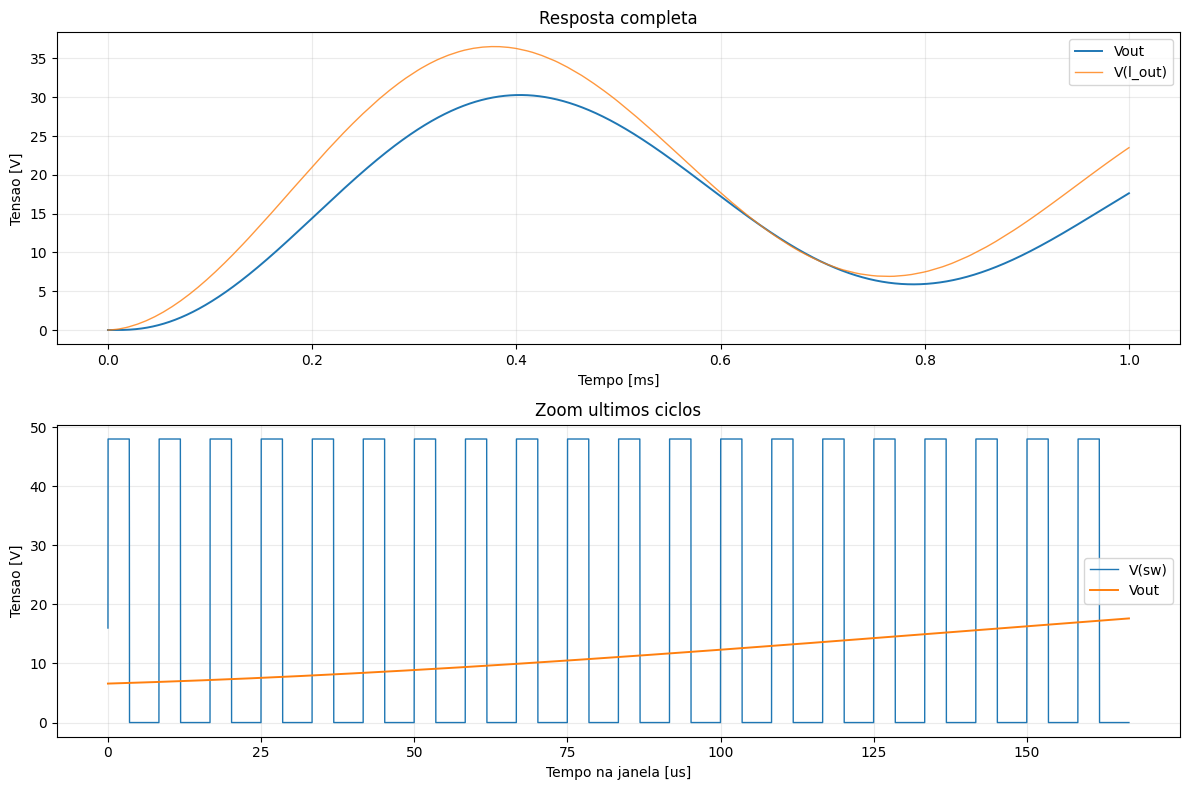

Resumo Vout:
  Vout final      : 17.6268 V
  Vout medio(last): 11.4350 V
  Ripple p-p(last): 11.0307 V


In [4]:
def _extract_waveform(res, idx):
    return np.array([state[idx] for state in res.states], dtype=float)

if result.success and len(result.time) > 2:
    t = np.array(result.time, dtype=float)
    v_sw = _extract_waveform(result, nodes["n_sw"])
    v_l = _extract_waveform(result, nodes["n_l"])
    v_out = _extract_waveform(result, nodes["n_out"])

    fsw = nodes["fsw"]
    window = 20.0 / fsw
    t_end = t[-1]
    mask_last = t >= max(t[0], t_end - window)

    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

    ax[0].plot(t * 1e3, v_out, lw=1.4, label="Vout")
    ax[0].plot(t * 1e3, v_l, lw=1.0, alpha=0.8, label="V(l_out)")
    ax[0].set_title("Resposta completa")
    ax[0].set_xlabel("Tempo [ms]")
    ax[0].set_ylabel("Tensao [V]")
    ax[0].grid(alpha=0.25)
    ax[0].legend(loc="best")

    ax[1].plot((t[mask_last] - t[mask_last][0]) * 1e6, v_sw[mask_last], lw=1.0, label="V(sw)")
    ax[1].plot((t[mask_last] - t[mask_last][0]) * 1e6, v_out[mask_last], lw=1.4, label="Vout")
    ax[1].set_title("Zoom ultimos ciclos")
    ax[1].set_xlabel("Tempo na janela [us]")
    ax[1].set_ylabel("Tensao [V]")
    ax[1].grid(alpha=0.25)
    ax[1].legend(loc="best")

    plt.tight_layout()
    plt.show()

    vout_final = float(v_out[-1])
    vout_mean_last = float(np.mean(v_out[mask_last]))
    vout_pp_last = float(np.max(v_out[mask_last]) - np.min(v_out[mask_last]))

    print("Resumo Vout:")
    print(f"  Vout final      : {vout_final:.4f} V")
    print(f"  Vout medio(last): {vout_mean_last:.4f} V")
    print(f"  Ripple p-p(last): {vout_pp_last:.4f} V")
else:
    print("A simulacao nao convergiu com o solver interno neste perfil.")
    print("Sugestao: reduzir rigidez (menos secoes RC) ou aumentar dt fixo.")


## 3) Simulacoes por backend/formulacao (incluindo HybridAuto)

Perfis SUNDIALS por familia:
- **projected**: `projected_wrapper`
- **direct_strict**: `direct` + `allow_formulation_fallback=False`
- **direct_auto**: `direct` + `allow_formulation_fallback=True`

Perfis HybridAuto adicionados:
- `HYBRID_AUTO_IDA`: modo `Auto` com reentrada nativa habilitada
- `HYBRID_AUTO_IDA_FORCED`: igual ao anterior, mas forca falha nativa para exercitar escalonamento

Cada perfil roda em:
- **cold-start** (t=0)
- **warm-start** (estado intermediario do Native)

Selecao para grafico final por backend (`SELECTION_POLICY`):
- `accuracy`: menor RMSE vs Native
- `speed`: menor tempo
- `balanced`: compromisso entre erro e tempo


In [5]:
def _formulation_to_text(formulation):
    if formulation == ps.SundialsFormulationMode.Direct:
        return "direct"
    return "projected_wrapper"


def _build_options_for_backend(
    mode,
    family=None,
    formulation=ps.SundialsFormulationMode.ProjectedWrapper,
    allow_formulation_fallback=True,
    enable_native_reentry=False,
    sundials_recovery_window=0.0,
    force_native_failure=False,
    warm_start=False,
    tstart=0.0,
    tstop=3.0e-4,
):
    o = ps.SimulationOptions()
    o.tstart = float(tstart)
    o.tstop = float(tstop)
    o.dt = 2.0e-8
    o.enable_events = True

    # Base
    o.max_step_retries = 14
    o.newton_options.max_iterations = 240
    o.newton_options.auto_damping = True
    o.linear_solver.allow_fallback = True
    o.linear_solver.auto_select = True

    o.transient_backend = mode

    if mode == ps.TransientBackendMode.Native:
        o.dt_min = o.dt
        o.dt_max = o.dt
        o.adaptive_timestep = False
        o.integrator = ps.Integrator.BDF1
        o.newton_options.max_iterations = 170
        o.max_step_retries = 6
    else:
        # Stress profile for SUNDIALS and Auto backends
        o.dt_min = 5.0e-11 if warm_start else 1.0e-12
        o.dt_max = 3.0e-6
        o.adaptive_timestep = True
        o.integrator = ps.Integrator.BDF1

        o.sundials.enabled = True
        o.sundials.family = family
        o.sundials.formulation = formulation
        o.sundials.allow_formulation_fallback = bool(allow_formulation_fallback)
        o.sundials.rel_tol = 7.5e-6 if warm_start else 1.0e-6
        o.sundials.abs_tol = 2.0e-7 if warm_start else 1.0e-9
        o.sundials.max_steps = 800000
        o.sundials.max_nonlinear_iterations = 20 if warm_start else 14
        o.sundials.use_jacobian = True

        # Direct strict gets extra headroom (no formulation fallback).
        if (formulation == ps.SundialsFormulationMode.Direct) and (not allow_formulation_fallback):
            o.sundials.max_steps = 1000000
            o.sundials.max_nonlinear_iterations = max(o.sundials.max_nonlinear_iterations, 24)
            o.dt_min = min(o.dt_min, 5.0e-13)

    if mode == ps.TransientBackendMode.Auto:
        o.fallback_policy.enable_backend_escalation = True
        o.fallback_policy.backend_escalation_threshold = 1
        o.fallback_policy.enable_native_reentry = bool(enable_native_reentry)
        o.fallback_policy.sundials_recovery_window = float(max(sundials_recovery_window, 0.0))

        if force_native_failure:
            # Deterministic stress: force native to fail quickly so Auto escalates.
            o.linear_solver.order = [ps.LinearSolverKind.CG]
            o.linear_solver.fallback_order = [ps.LinearSolverKind.CG]
            o.linear_solver.allow_fallback = False
            o.linear_solver.auto_select = False

    return o


def _run_backend_case(
    label,
    mode,
    family=None,
    formulation=ps.SundialsFormulationMode.ProjectedWrapper,
    formulation_tag="projected",
    allow_formulation_fallback=True,
    enable_native_reentry=False,
    sundials_recovery_window=0.0,
    force_native_failure=False,
    rc_sections=8,
    x0=None,
    warm_start=False,
    tstart=0.0,
    tstop=3.0e-4,
):
    ckt_case, nd = create_stress_converter(rc_sections=rc_sections)
    opts_case = _build_options_for_backend(
        mode=mode,
        family=family,
        formulation=formulation,
        allow_formulation_fallback=allow_formulation_fallback,
        enable_native_reentry=enable_native_reentry,
        sundials_recovery_window=sundials_recovery_window,
        force_native_failure=force_native_failure,
        warm_start=warm_start,
        tstart=tstart,
        tstop=tstop,
    )

    sim_case = ps.Simulator(ckt_case, opts_case)
    t0 = time.perf_counter()
    if x0 is None:
        res = sim_case.run_transient()
    else:
        res = sim_case.run_transient(np.asarray(x0, dtype=float))
    elapsed = time.perf_counter() - t0

    vout_final = float(res.states[-1][nd["n_out"]]) if res.states else float("nan")

    row = {
        "backend": label,
        "profile": "warm" if warm_start else "cold",
        "tstart_s": float(tstart),
        "success": bool(res.success),
        "elapsed_s": float(elapsed),
        "steps": int(res.total_steps),
        "samples": int(len(res.time)),
        "t_final_s": float(res.time[-1]) if res.time else 0.0,
        "vout_final": vout_final,
        "reinit_count": int(res.backend_telemetry.reinitialization_count),
        "event_count": int(len(res.events)),
        "message": str(res.message),
        "failure_reason": str(res.backend_telemetry.failure_reason),
        "selected_backend": str(res.backend_telemetry.selected_backend),
        "solver_family": str(res.backend_telemetry.solver_family),
        "formulation_req": _formulation_to_text(formulation),
        "formulation_tag": str(formulation_tag),
        "allow_formulation_fallback": bool(allow_formulation_fallback),
        "formulation_effective": str(res.backend_telemetry.formulation_mode),
    }
    return row, res, nd


In [6]:
RC_SECTIONS = 8
TSTOP_RUN = 3.0e-4
WARM_SEED_TARGET = min(2.0e-4, TSTOP_RUN * 0.6)
SELECTION_POLICY = "accuracy"  # "accuracy" | "speed" | "balanced"

families = [
    ("SUNDIALS_IDA", ps.SundialsSolverFamily.IDA),
    ("SUNDIALS_CVODE", ps.SundialsSolverFamily.CVODE),
    ("SUNDIALS_ARKODE", ps.SundialsSolverFamily.ARKODE),
]

formulation_profiles = [
    ("projected", ps.SundialsFormulationMode.ProjectedWrapper, True),
    ("direct_strict", ps.SundialsFormulationMode.Direct, False),
    ("direct_auto", ps.SundialsFormulationMode.Direct, True),
]

hybrid_profiles = [
    ("HYBRID_AUTO_IDA", ps.SundialsSolverFamily.IDA, False),
    ("HYBRID_AUTO_IDA_FORCED", ps.SundialsSolverFamily.IDA, True),
]


def _rmse_vs_native(native_res, native_nd, res_cmp, nd_cmp):
    if not (native_res.success and res_cmp.success):
        return float("inf")
    if len(native_res.time) < 5 or len(res_cmp.time) < 5:
        return float("inf")

    t_ref = np.asarray(native_res.time, dtype=float)
    y_ref = _extract_waveform(native_res, native_nd["n_out"])
    t_cmp = np.asarray(res_cmp.time, dtype=float)
    y_cmp = _extract_waveform(res_cmp, nd_cmp["n_out"])

    t0 = max(float(t_ref[0]), float(t_cmp[0]))
    t1 = min(float(t_ref[-1]), float(t_cmp[-1]))
    if t1 <= t0:
        return float("inf")

    mask = (t_ref >= t0) & (t_ref <= t1)
    if np.count_nonzero(mask) < 5:
        return float("inf")

    tref_overlap = t_ref[mask]
    yref_overlap = y_ref[mask]
    y_cmp_interp = np.interp(tref_overlap, t_cmp, y_cmp)
    err = y_cmp_interp - yref_overlap
    return float(np.sqrt(np.mean(err**2)))


def _select_profile(candidates, native_res, native_nd):
    successful = [c for c in candidates if c[1].success]
    if not successful:
        candidates.sort(key=lambda x: x[0]["t_final_s"], reverse=True)
        row_i, res_i, nd_i = candidates[0]
        return row_i, res_i, nd_i, "furthest_progress"

    if SELECTION_POLICY == "speed":
        successful.sort(key=lambda x: x[0]["elapsed_s"])
        row_i, res_i, nd_i = successful[0]
        return row_i, res_i, nd_i, f"elapsed_s={row_i['elapsed_s']:.3f}"

    if SELECTION_POLICY == "balanced" and native_res.success:
        scored = []
        for row_i, res_i, nd_i in successful:
            rmse = _rmse_vs_native(native_res, native_nd, res_i, nd_i)
            score = rmse + 0.25 * row_i["elapsed_s"]
            scored.append((score, rmse, row_i["elapsed_s"], row_i, res_i, nd_i))
        scored.sort(key=lambda x: (x[0], x[2]))
        _, rmse, elapsed, row_i, res_i, nd_i = scored[0]
        return row_i, res_i, nd_i, f"balanced(rmse={rmse:.6e},t={elapsed:.3f}s)"

    if native_res.success:
        scored = []
        for row_i, res_i, nd_i in successful:
            rmse = _rmse_vs_native(native_res, native_nd, res_i, nd_i)
            scored.append((rmse, row_i["elapsed_s"], row_i, res_i, nd_i))
        scored.sort(key=lambda x: (x[0], x[1]))
        rmse, _, row_i, res_i, nd_i = scored[0]
        return row_i, res_i, nd_i, f"rmse_vs_native={rmse:.6e}"

    successful.sort(key=lambda x: x[0]["elapsed_s"])
    row_i, res_i, nd_i = successful[0]
    return row_i, res_i, nd_i, f"elapsed_s={row_i['elapsed_s']:.3f}"


rows = []
results_by_backend = {}
nodes_by_backend = {}
selected_profile_by_backend = {}
selection_metric_by_backend = {}
all_runs = {}

# Native baseline (also used for warm-start seed)
native_row, native_res, native_nd = _run_backend_case(
    "Native",
    ps.TransientBackendMode.Native,
    family=None,
    formulation=ps.SundialsFormulationMode.ProjectedWrapper,
    formulation_tag="native",
    allow_formulation_fallback=True,
    rc_sections=RC_SECTIONS,
    x0=None,
    warm_start=False,
    tstart=0.0,
    tstop=TSTOP_RUN,
)
rows.append(native_row)
results_by_backend["Native"] = native_res
nodes_by_backend["Native"] = native_nd
selected_profile_by_backend["Native"] = "native/cold"
selection_metric_by_backend["Native"] = "baseline"
all_runs["Native"] = {"native": {"cold": (native_row, native_res, native_nd)}}

x0_warm = None
warm_seed_t = None
if native_res.success and len(native_res.time) > 8:
    t_native = np.asarray(native_res.time, dtype=float)
    warm_seed_t = min(WARM_SEED_TARGET, float(t_native[-1]) * 0.5)
    seed_idx = int(np.searchsorted(t_native, warm_seed_t, side="left"))
    seed_idx = min(max(seed_idx, 0), len(t_native) - 1)
    warm_seed_t = float(t_native[seed_idx])
    x0_warm = np.asarray(native_res.states[seed_idx], dtype=float)
    print(
        f"Warm-start state preparado do Native em t={warm_seed_t*1e6:.2f} us "
        f"(idx={seed_idx}, dim={x0_warm.size})"
    )
else:
    print("Native nao convergiu o suficiente para gerar warm-start; apenas cold-start sera testado.")

# SUNDIALS families
for backend_label, family in families:
    all_runs[backend_label] = {}

    for form_tag, formulation, allow_ff in formulation_profiles:
        all_runs[backend_label][form_tag] = {}

        cold_row, cold_res, cold_nd = _run_backend_case(
            backend_label,
            ps.TransientBackendMode.SundialsOnly,
            family=family,
            formulation=formulation,
            formulation_tag=form_tag,
            allow_formulation_fallback=allow_ff,
            rc_sections=RC_SECTIONS,
            x0=None,
            warm_start=False,
            tstart=0.0,
            tstop=TSTOP_RUN,
        )
        rows.append(cold_row)
        all_runs[backend_label][form_tag]["cold"] = (cold_row, cold_res, cold_nd)

        if x0_warm is not None and warm_seed_t is not None and warm_seed_t < TSTOP_RUN:
            warm_row, warm_res, warm_nd = _run_backend_case(
                backend_label,
                ps.TransientBackendMode.SundialsOnly,
                family=family,
                formulation=formulation,
                formulation_tag=form_tag,
                allow_formulation_fallback=allow_ff,
                rc_sections=RC_SECTIONS,
                x0=x0_warm,
                warm_start=True,
                tstart=warm_seed_t,
                tstop=TSTOP_RUN,
            )
            rows.append(warm_row)
            all_runs[backend_label][form_tag]["warm"] = (warm_row, warm_res, warm_nd)

    family_candidates = []
    for by_profile in all_runs[backend_label].values():
        family_candidates.extend(list(by_profile.values()))

    selected_row, selected_res, selected_nd, metric_txt = _select_profile(
        family_candidates, native_res, native_nd
    )

    results_by_backend[backend_label] = selected_res
    nodes_by_backend[backend_label] = selected_nd
    selected_profile_by_backend[backend_label] = (
        f"{selected_row['formulation_tag']}/{selected_row['profile']}"
    )
    selection_metric_by_backend[backend_label] = metric_txt

# Hybrid Auto profiles
for hybrid_label, family, force_native_failure in hybrid_profiles:
    all_runs[hybrid_label] = {"hybrid": {}}

    cold_row, cold_res, cold_nd = _run_backend_case(
        hybrid_label,
        ps.TransientBackendMode.Auto,
        family=family,
        formulation=ps.SundialsFormulationMode.Direct,
        formulation_tag="hybrid_forced" if force_native_failure else "hybrid_direct_auto",
        allow_formulation_fallback=True,
        enable_native_reentry=True,
        sundials_recovery_window=6.0e-5,
        force_native_failure=force_native_failure,
        rc_sections=RC_SECTIONS,
        x0=None,
        warm_start=False,
        tstart=0.0,
        tstop=TSTOP_RUN,
    )
    rows.append(cold_row)
    all_runs[hybrid_label]["hybrid"]["cold"] = (cold_row, cold_res, cold_nd)

    if x0_warm is not None and warm_seed_t is not None and warm_seed_t < TSTOP_RUN:
        warm_row, warm_res, warm_nd = _run_backend_case(
            hybrid_label,
            ps.TransientBackendMode.Auto,
            family=family,
            formulation=ps.SundialsFormulationMode.Direct,
            formulation_tag="hybrid_forced" if force_native_failure else "hybrid_direct_auto",
            allow_formulation_fallback=True,
            enable_native_reentry=True,
            sundials_recovery_window=6.0e-5,
            force_native_failure=force_native_failure,
            rc_sections=RC_SECTIONS,
            x0=x0_warm,
            warm_start=True,
            tstart=warm_seed_t,
            tstop=TSTOP_RUN,
        )
        rows.append(warm_row)
        all_runs[hybrid_label]["hybrid"]["warm"] = (warm_row, warm_res, warm_nd)

    candidates = list(all_runs[hybrid_label]["hybrid"].values())
    selected_row, selected_res, selected_nd, metric_txt = _select_profile(
        candidates, native_res, native_nd
    )

    results_by_backend[hybrid_label] = selected_res
    nodes_by_backend[hybrid_label] = selected_nd
    selected_profile_by_backend[hybrid_label] = (
        f"{selected_row['formulation_tag']}/{selected_row['profile']}"
    )
    selection_metric_by_backend[hybrid_label] = metric_txt

print(f"Selection policy: {SELECTION_POLICY}")
print("Resumo das simulacoes:")
print("-" * 246)
print(
    f"{'backend':<24} {'family':<14} {'form_req':<17} {'form_eff':<30} {'selected':<14} {'allow_ff':<8} {'profile':<8} "
    f"{'t0 [us]':>10} {'ok':<5} {'steps(loop)':>11} {'samples(out)':>12} {'reinit':>8} {'events':>8} "
    f"{'t_final [us]':>14} {'tempo [s]':>10} {'vout_final [V]':>14}"
)
print("-" * 246)
for r in rows:
    print(
        f"{r['backend']:<24} "
        f"{r['solver_family']:<14} "
        f"{r['formulation_tag'] + '/' + r['formulation_req']:<17} "
        f"{r['formulation_effective']:<30} "
        f"{r['selected_backend']:<14} "
        f"{str(r['allow_formulation_fallback']):<8} "
        f"{r['profile']:<8} "
        f"{r['tstart_s']*1e6:>10.3f} "
        f"{str(r['success']):<5} "
        f"{r['steps']:>11d} "
        f"{r['samples']:>12d} "
        f"{r['reinit_count']:>8d} "
        f"{r['event_count']:>8d} "
        f"{r['t_final_s']*1e6:>14.3f} "
        f"{r['elapsed_s']:>10.3f} "
        f"{r['vout_final']:>14.6f}"
    )

ok_runs = sum(1 for r in rows if r["success"])
print()
print(f"Convergencia geral: {ok_runs}/{len(rows)} execucoes")
if ok_runs == len(rows):
    print("Todos os perfis convergiram neste setup.")

print()
print("Mensagem final por execucao:")
for r in rows:
    print(
        f"- {r['backend']} [{r['formulation_tag']}|{r['profile']}|t0={r['tstart_s']*1e6:.1f}us]: "
        f"{r['message']}"
    )

print()
print("Perfil selecionado para os graficos/comparacao:")
ordered_labels = [
    "Native",
    "SUNDIALS_IDA",
    "SUNDIALS_CVODE",
    "SUNDIALS_ARKODE",
    "HYBRID_AUTO_IDA",
    "HYBRID_AUTO_IDA_FORCED",
]
for label in ordered_labels:
    if label in selected_profile_by_backend:
        metric = selection_metric_by_backend.get(label, "")
        suffix = f" ({metric})" if metric else ""
        print(f"- {label}: {selected_profile_by_backend[label]}{suffix}")


Warm-start state preparado do Native em t=150.00 us (idx=7500, dim=12)



[IDA ERROR]  IDASolve
  At t = 0 and h = 5e-15, the error test failed repeatedly or with |h| = hmin.


[IDA ERROR]  IDACalcIC
  The residual routine or the linear setup or solve routine had a recoverable error, but IDACalcIC was unable to recover.


[IDA ERROR]  IDASolve
  At t = 0 and h = 1e-14, the error test failed repeatedly or with |h| = hmin.


[IDA ERROR]  IDACalcIC
  The residual routine or the linear setup or solve routine had a recoverable error, but IDACalcIC was unable to recover.


[CVODE ERROR]  CVode
  At t = 1.12496e-06 repeated recoverable right-hand side function errors.


[CVODE ERROR]  CVode
  At t = 0.000150019 repeated recoverable right-hand side function errors.


[CVODE ERROR]  CVode
  At t = 1.12649e-06 repeated recoverable right-hand side function errors.


[CVODE ERROR]  CVode
  At t = 0.000150025 and h = 1.5625e-13, the error test failed repeatedly or with |h| = hmin.



Selection policy: accuracy
Resumo das simulacoes:
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
backend          family  form_req          form_eff                       allow_ff profile     t0 [us] ok    steps(loop) samples(out)   reinit   events   t_final [us]  tempo [s] vout_final [V]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Native           native  native/projected_wrapper native                         True     cold          0.000 True        15000        15001        0        0        300.000      0.064      25.550553
SUNDIALS_IDA     ida     projected/projected_wrapper projected_wrapper              True     cold  


[ARKODE ERROR]  ARKODE
  At t = 4.63477e-07 repeated recoverable right-hand side function errors.


[ARKODE ERROR]  ARKODE
  At t = 0.00015 repeated recoverable right-hand side function errors.


[ARKODE ERROR]  ARKODE
  At t = 4.63476e-07 repeated recoverable right-hand side function errors.


[ARKODE ERROR]  ARKODE
  At t = 0.00015 repeated recoverable right-hand side function errors.



Backends convergidos (perfil selecionado):
- Native [native/cold]
- SUNDIALS_IDA [direct_auto/cold]
- SUNDIALS_CVODE [projected/cold]
- SUNDIALS_ARKODE [projected/cold]


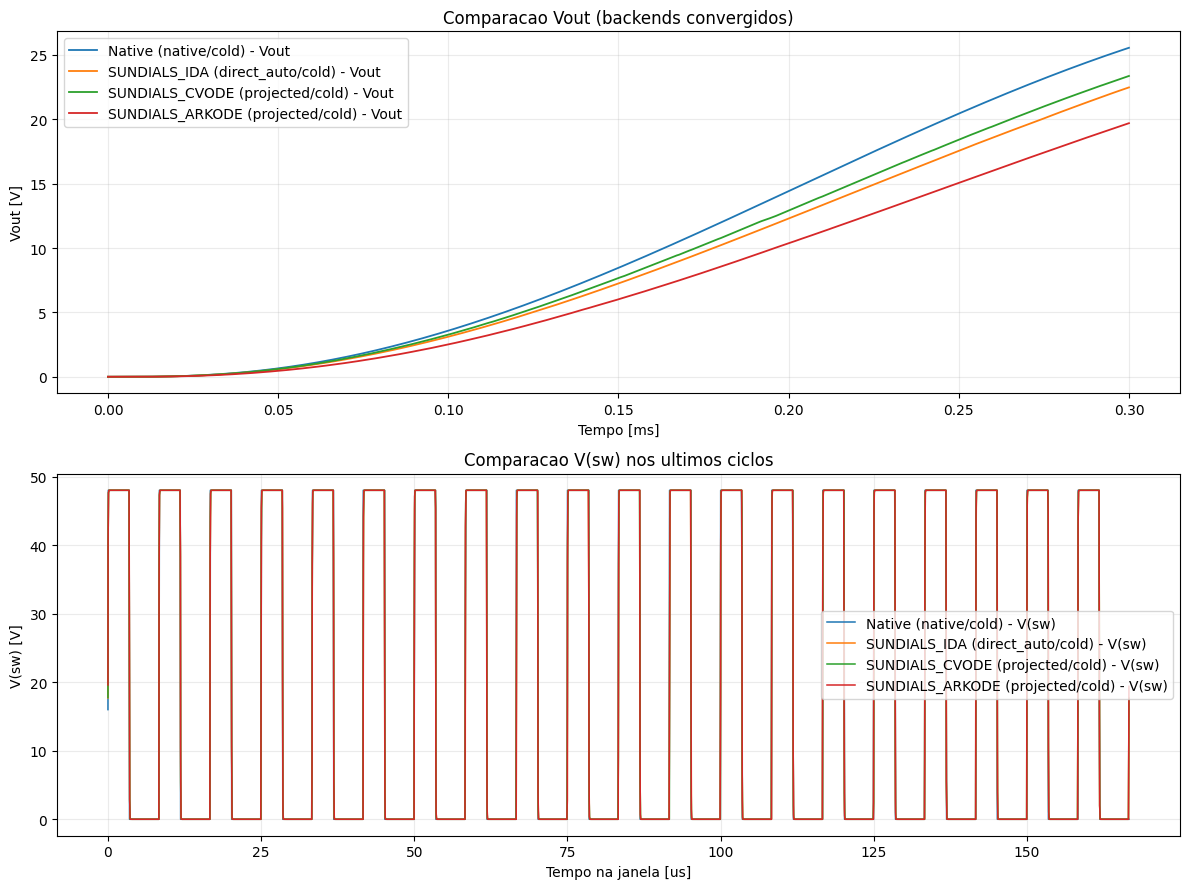

In [7]:
def _decimate_xy(t, y, max_points=6000):
    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)
    if t.size <= max_points:
        return t, y
    idx = np.linspace(0, t.size - 1, max_points, dtype=int)
    return t[idx], y[idx]


success_labels = [label for label, res in results_by_backend.items() if res.success and len(res.time) > 2]
print("Backends convergidos (perfil selecionado):")
for label in success_labels:
    print(f"- {label} [{selected_profile_by_backend.get(label, 'cold')}]")

if len(success_labels) == 0:
    print("Nenhum backend convergiu neste perfil de estresse.")
else:
    fig, ax = plt.subplots(2, 1, figsize=(12, 9), sharex=False)

    for label in success_labels:
        res = results_by_backend[label]
        nd = nodes_by_backend[label]
        profile = selected_profile_by_backend.get(label, "cold")

        t = np.asarray(res.time, dtype=float)
        vout = _extract_waveform(res, nd["n_out"])
        vsw = _extract_waveform(res, nd["n_sw"])

        td, voutd = _decimate_xy(t, vout)
        ax[0].plot(td * 1e3, voutd, lw=1.3, label=f"{label} ({profile}) - Vout")

        fsw = nd["fsw"]
        window = 20.0 / fsw
        t_end = t[-1]
        mask = t >= max(t[0], t_end - window)
        tw = t[mask]
        vsww = vsw[mask]
        if tw.size > 2:
            twd, vswwd = _decimate_xy(tw, vsww, max_points=2500)
            ax[1].plot((twd - twd[0]) * 1e6, vswwd, lw=1.1, label=f"{label} ({profile}) - V(sw)")

    ax[0].set_title("Comparacao Vout (backends convergidos)")
    ax[0].set_xlabel("Tempo [ms]")
    ax[0].set_ylabel("Vout [V]")
    ax[0].grid(alpha=0.25)
    ax[0].legend(loc="best")

    ax[1].set_title("Comparacao V(sw) nos ultimos ciclos")
    ax[1].set_xlabel("Tempo na janela [us]")
    ax[1].set_ylabel("V(sw) [V]")
    ax[1].grid(alpha=0.25)
    ax[1].legend(loc="best")

    plt.tight_layout()
    plt.show()



In [8]:
# Diferencas numericas vs Native (somente para casos convergidos)

if "Native" in results_by_backend and results_by_backend["Native"].success and len(results_by_backend["Native"].time) > 5:
    r_native = results_by_backend["Native"]
    nd_native = nodes_by_backend["Native"]

    t_ref = np.asarray(r_native.time, dtype=float)
    y_ref = _extract_waveform(r_native, nd_native["n_out"])

    compared = False
    labels_to_compare = [k for k in results_by_backend.keys() if k != "Native"]

    for label in labels_to_compare:
        r_cmp = results_by_backend[label]
        if not r_cmp.success or len(r_cmp.time) < 5:
            continue

        nd_cmp = nodes_by_backend[label]
        t_cmp = np.asarray(r_cmp.time, dtype=float)
        y_cmp = _extract_waveform(r_cmp, nd_cmp["n_out"])

        t0 = max(float(t_ref[0]), float(t_cmp[0]))
        t1 = min(float(t_ref[-1]), float(t_cmp[-1]))
        if t1 <= t0:
            print(f"{label} vs Native -> sem janela temporal comum para comparar")
            continue

        mask = (t_ref >= t0) & (t_ref <= t1)
        if np.count_nonzero(mask) < 5:
            print(f"{label} vs Native -> janela comum muito curta")
            continue

        tref_overlap = t_ref[mask]
        yref_overlap = y_ref[mask]

        # Interpola sinal comparado na base temporal do Native (janela comum)
        y_cmp_interp = np.interp(tref_overlap, t_cmp, y_cmp)
        err = y_cmp_interp - yref_overlap

        mae = float(np.mean(np.abs(err)))
        rmse = float(np.sqrt(np.mean(err**2)))
        emax = float(np.max(np.abs(err)))

        print(
            f"{label} ({selected_profile_by_backend.get(label, 'cold')}) vs Native "
            f"[t={t0*1e6:.1f}..{t1*1e6:.1f}us] -> "
            f"MAE={mae:.6e} V | RMSE={rmse:.6e} V | MAX={emax:.6e} V"
        )
        compared = True

    if not compared:
        print("Nenhum backend adicional convergiu para comparar com Native neste perfil.")
else:
    print("Native nao convergiu; comparacao de erro nao disponivel.")


SUNDIALS_IDA (direct_auto/cold) vs Native [t=0.0..300.0us] -> MAE=1.389675e+00 V | RMSE=1.801910e+00 V | MAX=3.113305e+00 V
SUNDIALS_CVODE (projected/cold) vs Native [t=0.0..300.0us] -> MAE=9.620650e-01 V | RMSE=1.258526e+00 V | MAX=2.202012e+00 V
SUNDIALS_ARKODE (projected/cold) vs Native [t=0.0..300.0us] -> MAE=2.678843e+00 V | RMSE=3.411054e+00 V | MAX=5.864002e+00 V
